# Exploring Music Structure and Clustering in Spotify Tracks Using Unsupervised Learning

## Data Preparation

In [3]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from matplotlib.colors import ListedColormap
import warnings

In [4]:
# Loading Dataset
spotify_df = pd.read_csv('SpotifyFeatures.csv')

In [5]:
spotify_df.head(5)

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0.000  F#    0.1510    -5.559  Minor   
2       170267   0.131             0.000   C    0.1030   -13.879  Minor   
3       152427   0.326             0.000  C#    0.0985   -12.178  Major   
4        82625   0.225             0.123   F    0.2020   -21.150  Major   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969            4/4    0.814  
1       0.0868  174.003            4/4    0.816  
2       0.0362   99.488            5/4    0.368  
3       0.0395  171.758            4/4    0.227  
4       0.0456  140.576            4/4    0.390

In [6]:
# Data Exploration
# Total Rows
total_rows = len(spotify_df)
print("Total number of rows:", total_rows)

Total number of rows: 232725


In [7]:
# Data Description
spotify_df.info()
spotify_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

popularity   acousticness   danceability   duration_ms  \
count  232725.000000  232725.000000  232725.000000  2.327250e+05   
mean       41.127502       0.368560       0.554364  2.351223e+05   
std        18.189948       0.354768       0.185608  1.189359e+05   
min         0.000000       0.000000       0.056900  1.538700e+04   
25%        29.000000       0.037600       0.435000  1.828570e+05   
50%        43.000000       0.232000       0.571000  2.204270e+05   
75%        55.000000       0.722000       0.692000  2.657680e+05   
max       100.000000       0.996000       0.989000  5.552917e+06   

              energy  instrumentalness       liveness       loudness  \
count  232725.000000     232725.000000  232725.000000  232725.000000   
mean        0.570958          0.148301       0.215009      -9.569885   
std         0.263456          0.302768       0.198273       5.998204   
min         0.000020          0.000000       0.009670     -52.457000   
25%         0.385000          0.000000       0.097400     -11.771000   
50%         0.605000          0.000044       0.128000      -7.762000   
75%         0.787000          0.035800       0.264000      -5.501000   
max         0.999000          0.999000       1.000000       3.744000   

         speechiness          tempo        valence  
count  232725.000000  232725.000000  232725.000000  
mean        0.120765     117.666585       0.454917  
std         0.185518      30.898907       0.260065  
min         0.022200      30.379000       0.000000  
25%         0.036700      92.959000       0.237000  
50%         0.050100     115.778000       0.444000  
75%         0.105000     139.054000       0.660000  
max         0.967000     242.903000       1.000000

In [8]:
# Unique Features
print("Number of unique genres:", spotify_df['genre'].nunique())
print("Number of unique artist names:", spotify_df['artist_name'].nunique())
print("Number of unique track IDs:", spotify_df['track_id'].nunique())

Number of unique genres: 27
Number of unique artist names: 14564
Number of unique track IDs: 176774


In [9]:
# Duplicate Track ID count
count = spotify_df['track_id'].value_counts()
num_duplicated_ids = (count > 1).sum()
print("Number of unique track ID values that are duplicated:", num_duplicated_ids)

Number of unique track ID values that are duplicated: 35124


In [10]:
# Inspect a Duplicated Track 
first_duplicate_id = spotify_df[spotify_df.duplicated(subset='track_id', keep='first')]['track_id'].iloc[0]
print("First duplicated track_id:", first_duplicate_id)
spotify_df[spotify_df['track_id'] == first_duplicate_id]

First duplicated track_id: 6iOvnACn4ChlAw4lWUU4dd


genre artist_name  track_name                track_id  \
257                  R&B    Doja Cat  Go To Town  6iOvnACn4ChlAw4lWUU4dd   
1348         Alternative    Doja Cat  Go To Town  6iOvnACn4ChlAw4lWUU4dd   
77710   Children’s Music    Doja Cat  Go To Town  6iOvnACn4ChlAw4lWUU4dd   
93651              Indie    Doja Cat  Go To Town  6iOvnACn4ChlAw4lWUU4dd   
113770               Pop    Doja Cat  Go To Town  6iOvnACn4ChlAw4lWUU4dd   

        popularity  acousticness  danceability  duration_ms  energy  \
257             64        0.0716          0.71       217813    0.71   
1348            64        0.0716          0.71       217813    0.71   
77710           64        0.0716          0.71       217813    0.71   
93651           64        0.0716          0.71       217813    0.71   
113770          64        0.0716          0.71       217813    0.71   

        instrumentalness key  liveness  loudness   mode  speechiness    tempo  \
257             0.000001   C     0.206    -2.474  Major       0.0579  169.944   
1348            0.000001   C     0.206    -2.474  Major       0.0579  169.944   
77710           0.000001   C     0.206    -2.474  Major       0.0579  169.944   
93651           0.000001   C     0.206    -2.474  Major       0.0579  169.944   
113770          0.000001   C     0.206    -2.474  Major       0.0579  169.944   

       time_signature  valence  
257               4/4      0.7  
1348              4/4      0.7  
77710             4/4      0.7  
93651             4/4      0.7  
113770            4/4      0.7

In [11]:
# Clean duplicated Tracks
spotify_df= spotify_df.drop_duplicates(subset=['track_id'])
count = spotify_df['track_id'].value_counts()
num_duplicated_ids = (count > 1).sum()
print("Number of unique tracks that are duplicated after cleaning:", num_duplicated_ids)

Number of unique tracks that are duplicated after cleaning: 0


In [12]:
# Strip Leading/Trailing Whitespace and Fix Case 
spotify_df['genre'] = spotify_df['genre'].str.replace('’', "'", regex=False)
spotify_df['genre'].unique()

array(['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
       'Electronic', 'Anime', 'Folk', 'Blues', 'Opera', 'Hip-Hop',
       "Children's Music", 'Rap', 'Indie', 'Classical', 'Pop', 'Reggae',
       'Reggaeton', 'Jazz', 'Rock', 'Ska', 'Comedy', 'Soul', 'Soundtrack',
       'World'], dtype=object)

## EDA

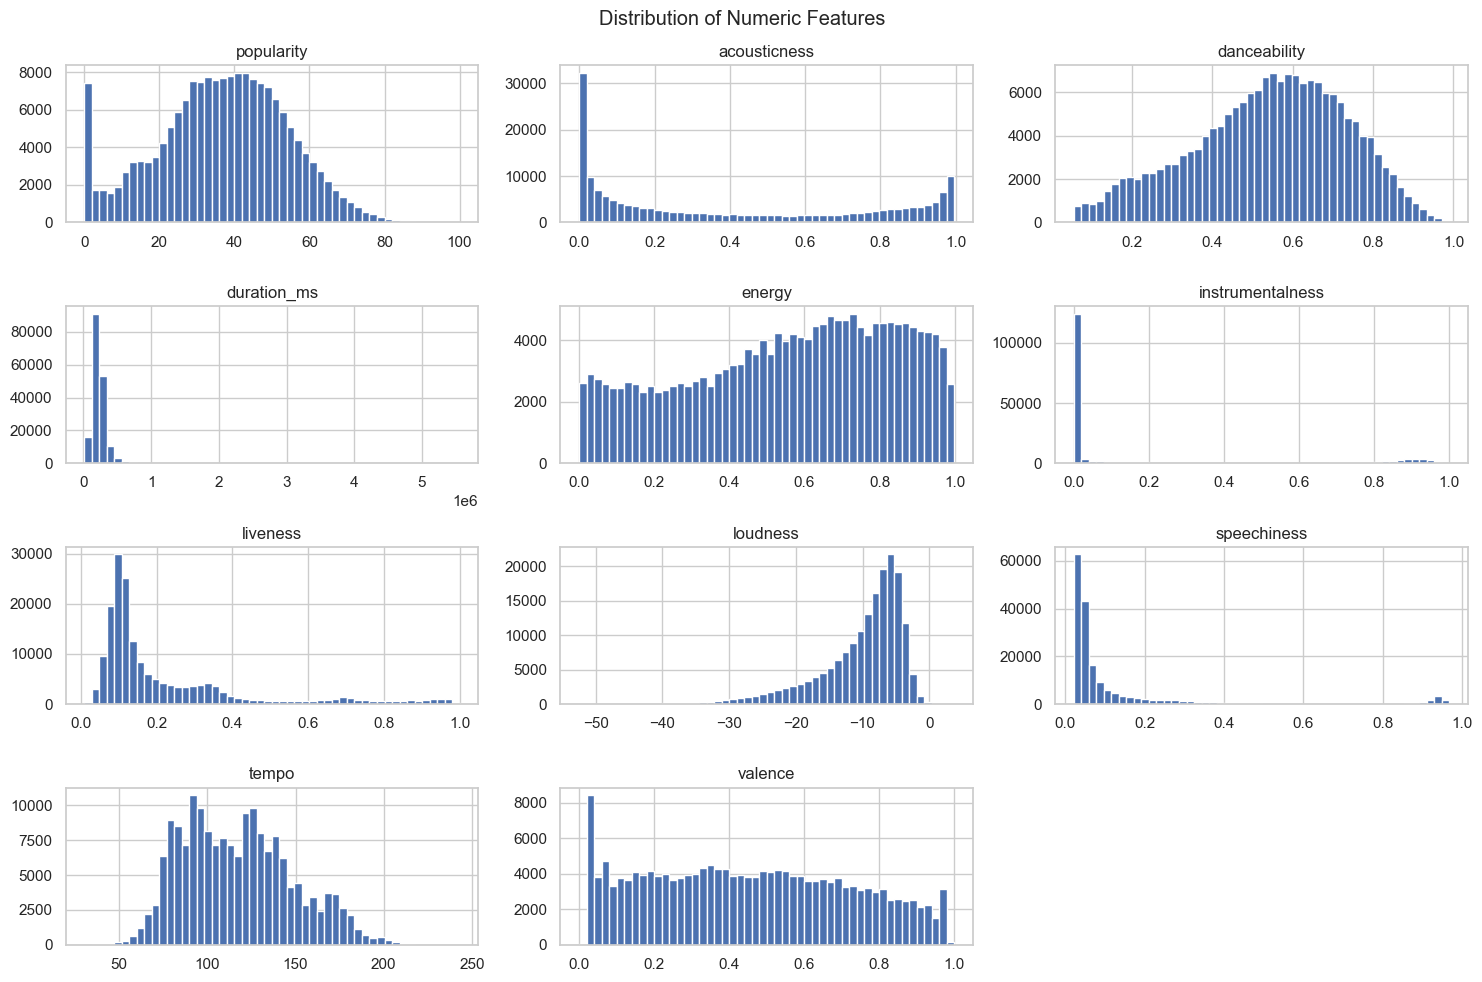

In [14]:
# Data Visualisation
sns.set(style='whitegrid')

# Select Numeric Columns 
df_numeric = spotify_df.select_dtypes(include='number')

# Plot Histograms
df_numeric.hist(bins=50, figsize=(15, 10))
plt.suptitle('Distribution of Numeric Features')
plt.tight_layout()
plt.show()

* As we can see time, instrumentalness and speechiness are highly skewed, it requires transformation before scaling it to reduce variance.

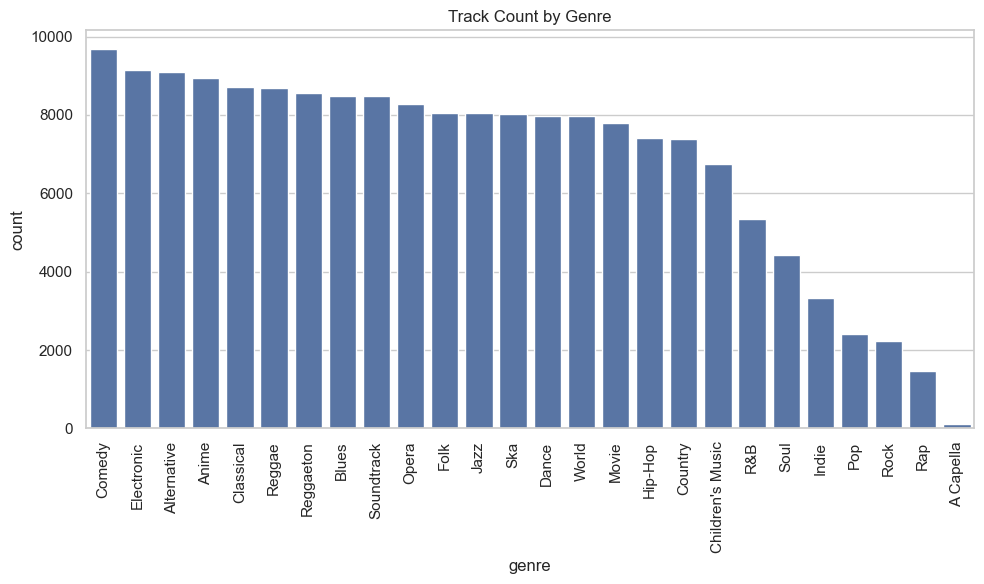

In [16]:
# Genre Distribution
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='genre', data=spotify_df, order=spotify_df['genre'].value_counts().index)
plt.title('Track Count by Genre')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

* So, in total there are 26 different genre and sample size of each genre is almost above 600 expet some and henxce there is no highly imbalance in the dataset.

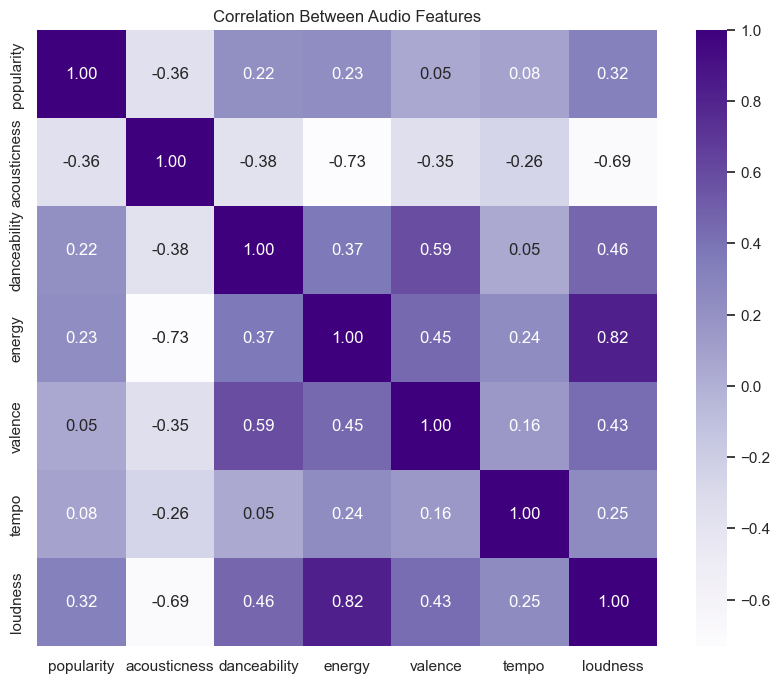

In [18]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
features = ['popularity', 'acousticness', 'danceability', 'energy', 'valence', 'tempo', 'loudness']
corr = spotify_df[features].corr()
sns.heatmap(corr, annot=True, cmap='Purples', fmt=".2f")
plt.title('Correlation Between Audio Features')
plt.show()

* As we can see from above plot, popularity is weekly correlated with other musical features and hence it is not highlt correlated.
* While, energy and acoustiness are negatively correalted and loudness is positively correlated with energy.

## Data Transformation

In [21]:
# Log Transformation
spotify_df['duration_ms'] = np.log1p(spotify_df['duration_ms'])
spotify_df['instrumentalness'] = np.log1p(spotify_df['instrumentalness'])
spotify_df['speechiness'] = np.log1p(spotify_df['speechiness'])

# Encode Categorical Data
for col in ['key', 'mode', 'time_signature']:
    le = LabelEncoder()
    spotify_df[col] = le.fit_transform(spotify_df[col])

#Drop Columns
spotify_df_cleaned = spotify_df.drop(columns=['track_id', 'artist_name', 'track_name'])

features = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
            'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
            'valence']

# Scale features
scaler = StandardScaler()
spotify_scaled = scaler.fit_transform(spotify_df_cleaned[features])

# Create DataFrame 
spotify_scaled_df = pd.DataFrame(spotify_scaled, columns=features)

### Method-1:Principal Component Analysis

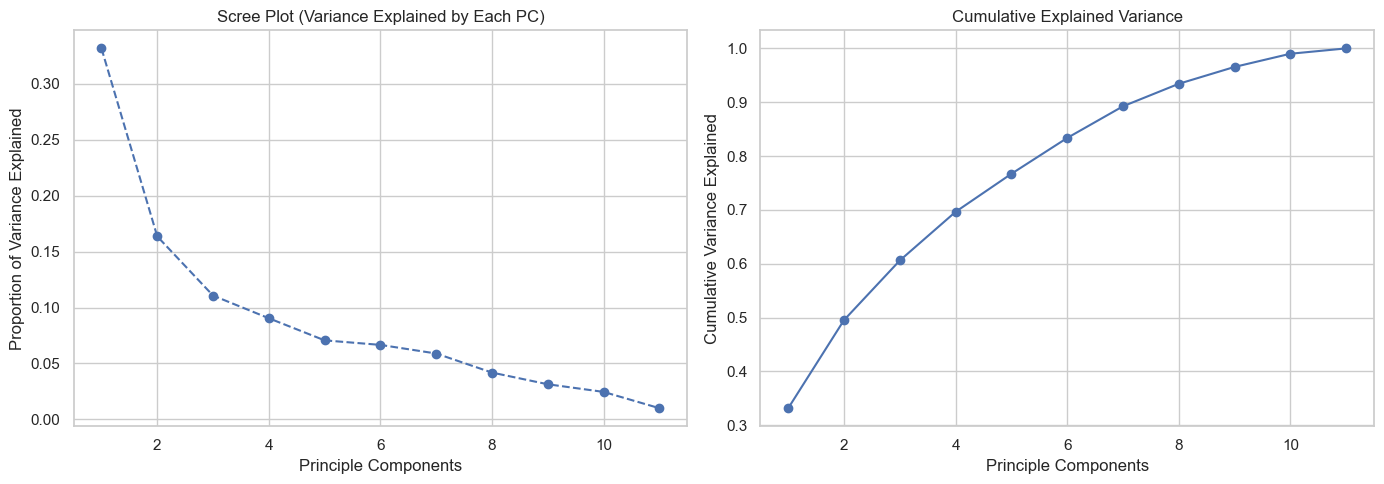

In [23]:
# Performing PCA
pca = PCA()
spotify_pca = pca.fit_transform(spotify_scaled_df)

# Proportion of Variance Explained by Each Component
explained_variance = pca.explained_variance_ratio_

# Cumulative Variance Explained
cumulative_variance = np.cumsum(explained_variance)

# Plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linestyle='--')
axs[0].set_title("Scree Plot (Variance Explained by Each PC)")
axs[0].set_xlabel("Principle Components")
axs[0].set_ylabel("Proportion of Variance Explained")
axs[0].grid(True)

axs[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='-')
axs[1].set_title("Cumulative Explained Variance")
axs[1].set_xlabel("Principle Components")
axs[1].set_ylabel("Cumulative Variance Explained")
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### Compare the PC1-PC2 scatter plot with a scatter of two original features (for example, energy vs. danceability) and provide interpretation.

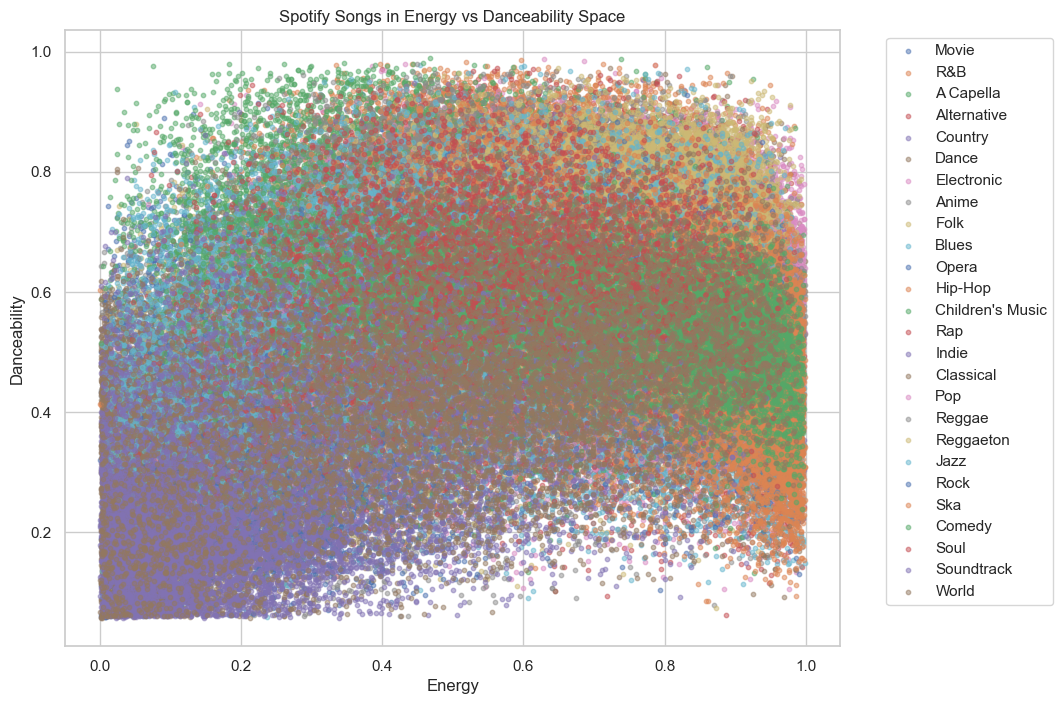

In [25]:
plt.figure(figsize=(10, 8))
for genre in spotify_df['genre'].unique():
    subset = spotify_df[spotify_df['genre'] == genre]
    plt.scatter(subset['energy'], subset['danceability'], label=genre, alpha=0.5, s=10)
plt.title('Spotify Songs in Energy vs Danceability Space')
plt.xlabel('Energy')
plt.ylabel('Danceability')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


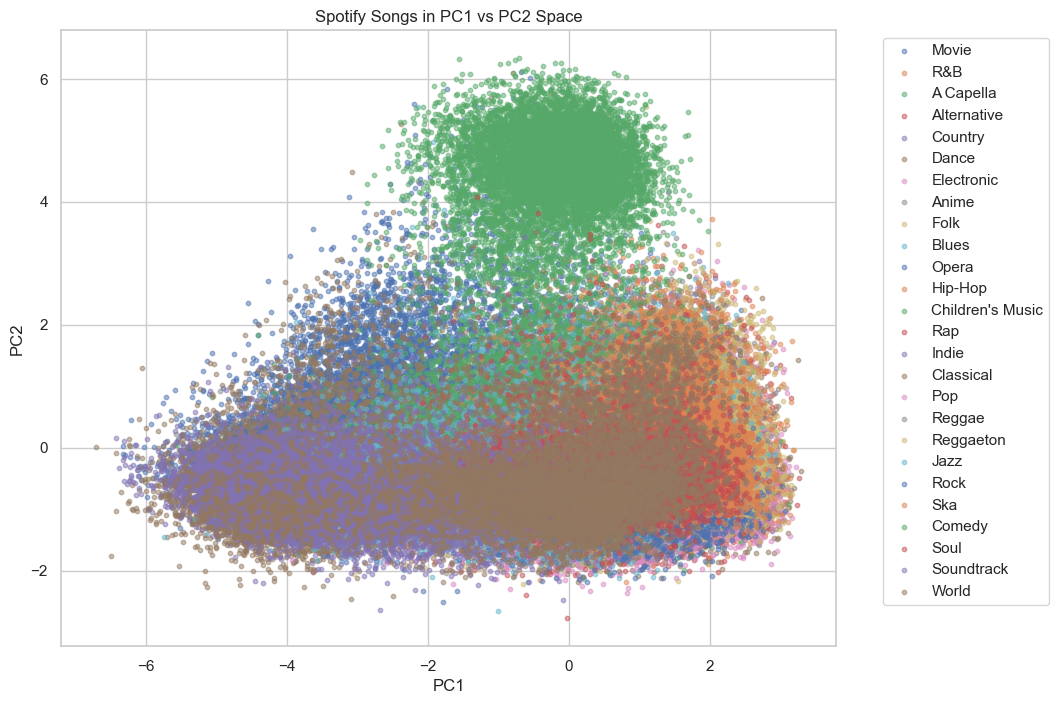

In [26]:
# DataFrame for PCA results with PC1, PC2, and Genre
spotify_pca_df = pd.DataFrame(spotify_pca[:, :2], columns=['PC1', 'PC2'])
spotify_pca_df['genre'] = spotify_df['genre'].values  # Include genre for color coding

# Plot PC1 vs PC2 with Genre Colors
plt.figure(figsize=(10, 8))
for genre in spotify_pca_df['genre'].unique():
    subset = spotify_pca_df[spotify_pca_df['genre'] == genre]
    plt.scatter(subset['PC1'], subset['PC2'], label=genre, alpha=0.5, s=10)
plt.title('Spotify Songs in PC1 vs PC2 Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Spotify Songs in PC1 vs PC2 Space
When we mapped Spotify’s entire music catalog into PCA space, something amazing happened. Suddenly, thousands of songs—each with their unique rhythm and energy—compressed into a neat, two-dimensional scatterplot. Here, each point represents a song, blending a cocktail of features like energy, danceability, valence, and more.

What’s striking is how some genres (shown by clusters of similar colors) seem to gravitate toward each other. It’s as if PCA exposes invisible musical friendships, revealing which genres share common audio traits. Compared to the messy overlaps of the original features, this PCA view gives a much clearer picture of Spotify’s musical landscape.

Spotify Songs in Energy vs Danceability Space
Now, when we look at a plot based solely on energy and danceability, the story changes. Sure, these two features tell us a lot about mood and movement, but the overall spread is much more uniform. Genres blend together here, making it harder to distinguish one from another.

It’s a reminder that while these features are important, they’re just two threads in the rich tapestry of musical characteristics. Many nuances—like tempo, loudness, or valence—get lost when we focus on only two features.

### Method-2: K-means Clustering

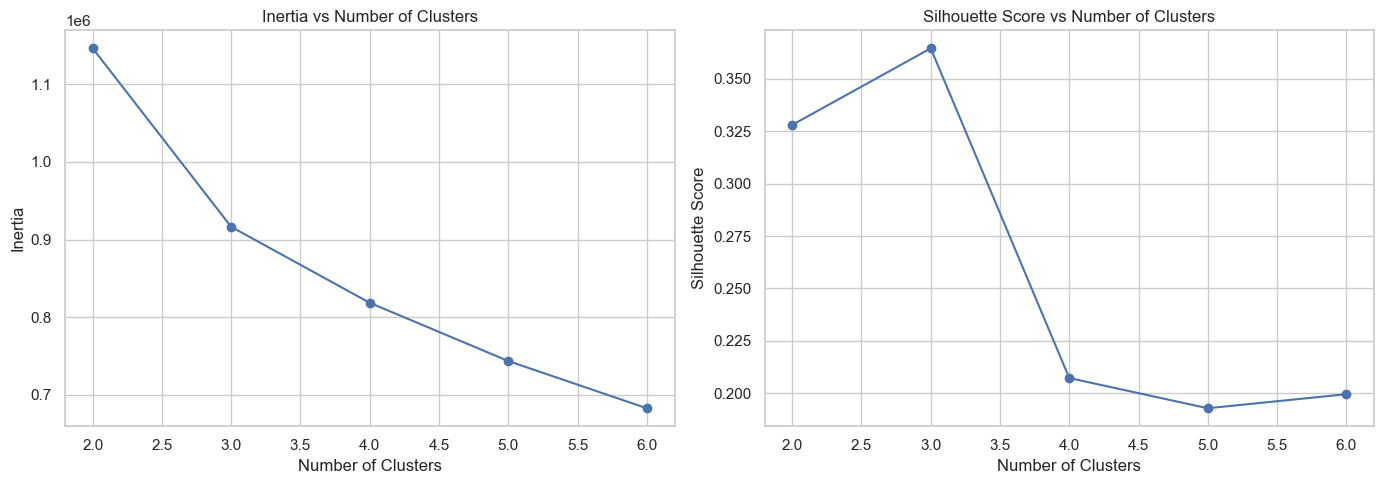

In [29]:
# Performing K-Means
inertias = []
silhouette_scores = []
k_range = range(2, 7) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=100, n_init=5)
    kmeans.fit(spotify_pca[:, :6]) 
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(spotify_pca[:, :6], kmeans.labels_))

# Plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(k_range, inertias, marker='o')
axs[0].set_title('Inertia vs Number of Clusters')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Inertia')
axs[0].grid(True)

axs[1].plot(k_range, silhouette_scores, marker='o')
axs[1].set_title('Silhouette Score vs Number of Clusters')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Silhouette Score')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [30]:
warnings.filterwarnings("ignore")

# Apply KMeans on PC1 and PC2
kmeans = KMeans(n_clusters=3, random_state=42)
spotify_df['cluster'] = kmeans.fit_predict(spotify_pca[:, [0, 1]])  

# Define track names from history
tracks = ['Shinunoga E-Wa', 'DNA.', 'Heat Waves', 'Older', 'Lovely', 
          'YOUTH', 'Jesus in LA', 'Feelings']

df = spotify_df[spotify_df['track_name'].isin(tracks)].drop_duplicates(subset='track_name')

ypca = pca.transform(scaler.transform(df[features]))
yclusters = kmeans.predict(ypca[:, [0, 1]])

history_clusters = pd.DataFrame({
    'track_name': df['track_name'].values,
    'cluster': yclusters
})
print("Listening History Cluster Assignments (on PC1 & PC2):")
print(history_clusters.sort_values('cluster'))

Listening History Cluster Assignments (on PC1 & PC2):
  track_name  cluster
0     Lovely        1
1      YOUTH        1
2   Feelings        1
3       DNA.        1
4      Older        1


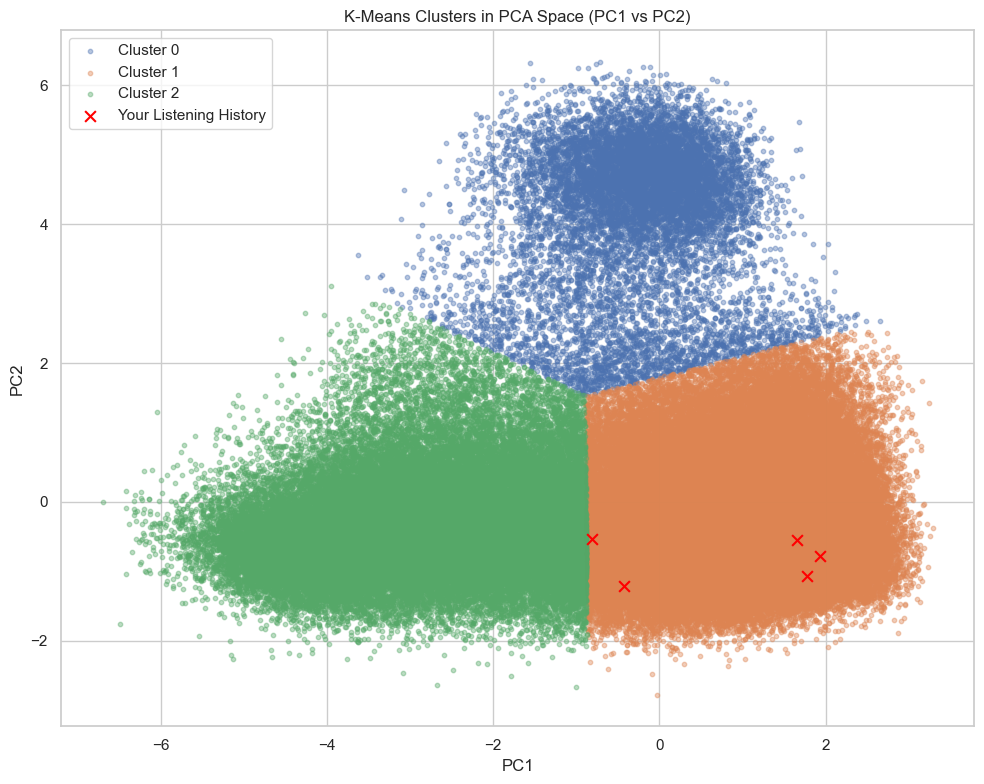

In [31]:
plt.figure(figsize=(10, 8))
for cluster in range(3):
    idx = spotify_df['cluster'] == cluster
    plt.scatter(spotify_pca[idx, 0], spotify_pca[idx, 1], label=f'Cluster {cluster}', s=10, alpha=0.4)

plt.scatter(ypca[:, 0], ypca[:, 1], color='red', s=60, marker='x', label='Your Listening History')

plt.title('K-Means Clusters in PCA Space (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

When we visualized our listening history—featuring tracks like “Shinunoga E-Wa,” “DNA.,” “Heat Waves,” “Older,” “Lovely,” “YOUTH,” “Jesus in LA,” and “Feelings”—against the Spotify dataset using principal component analysis (PCA), we uncovered some insightful patterns about our musical preferences.

This scatter plot shows every song as a dot in a two-dimensional PCA space, where complex audio characteristics (like energy, valence, danceability, tempo, and more) are compressed into principal components. These dimensions essentially capture the underlying structure of Spotify’s sonic universe.

Our listening history appears as bold red X’s lies on the clusters formed by all other songs. While not all tracks from our list were present in the dataset, the ones that were tend to fall within specific clusters—suggesting shared audio traits. For example, these songs may repreent a cluster of high energy, high loudness  and lower aucosticness that places them within a distinct musical neighborhood.

From the plot, we notice our points concentrate in just one the K-Means-defined clusters. This suggests that, despite believing our tastes are broad, the music we gravitate toward may share less obvious similarities—possibly in style such as pop, or tempo.

By looking at this visualization, we’re not just seeing songs—we’re seeing how we fit into Spotify’s greater musical landscape. And what emerges is a clear signal: our favorite tracks are more aligned than we might have guessed.

### Projecting our song history

In [34]:
# Find your listening history cluster assignments
our_tracks1 = [
    ('Shinunoga E-Wa', 'Fujii Kaze'),
    ('DNA.', 'Kendrick Lamar'),
    ('Heat Waves', 'Glass Animals'),
    ('Older', 'Alec Benjamin'),
    ('Lovely', 'Billie Eilish, Khalid'), 
    ('YOUTH', 'Troye Sivan'),
    ('Jesus in LA', 'Alec Benjamin'),
    ('Feelings', 'Lauv')
]
our_df1 = spotify_df[spotify_df['track_name'].isin(our_tracks1)]
our_clusters = our_df1['cluster'].unique()
print("Our Listening History Clusters:", our_clusters)

# Summarize each cluster's characteristics
cluster_summary = spotify_df.groupby('cluster').mean(numeric_only=True)[['energy', 'danceability', 'valence', 'tempo', 'loudness']]
print(cluster_summary)

Our Listening History Clusters: []
           energy  danceability   valence       tempo   loudness
cluster                                                         
0        0.634370      0.563016  0.436753   99.494586 -11.973442
1        0.679857      0.608193  0.541089  123.279613  -7.027304
2        0.198740      0.350731  0.209675  105.264790 -18.190846


### Projecting some interpretable data into PCA space

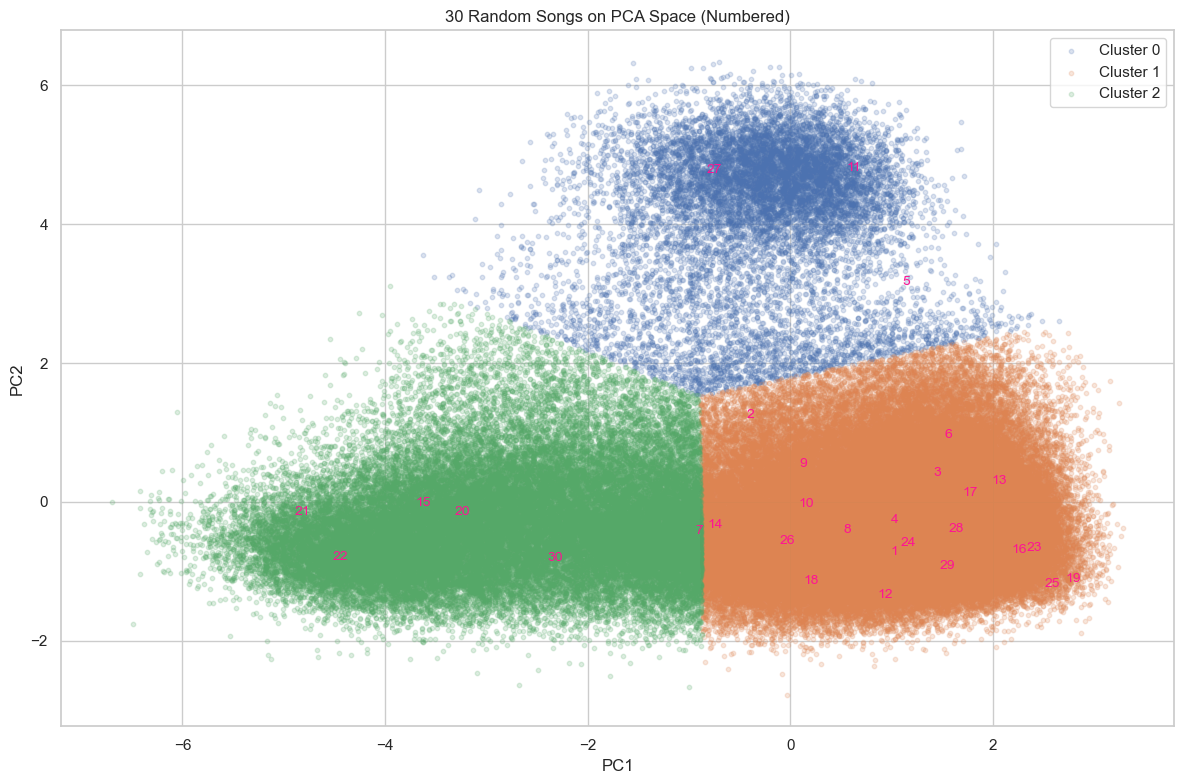

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# selecting 30 random songs from dataset
np.random.seed(42)
songs = spotify_df.drop_duplicates(subset=['track_name', 'artist_name']).sample(30, random_state=158)
scaled = scaler.transform(songs[features])


random_pca = pca.transform(scaled)
clusters = kmeans.predict(random_pca[:, [0, 1]])

songs =songs.copy()
songs['Cluster'] = clusters
plt.figure(figsize=(12, 8))
for cluster in range(3):
    idx = spotify_df['cluster'] == cluster
    plt.scatter(spotify_pca[idx, 0], spotify_pca[idx, 1],
                label=f'Cluster {cluster}', s=10, alpha=0.2, color=f'C{cluster}')

for i, (x, y) in enumerate(zip(random_pca[:, 0], random_pca[:, 1]), 1):
    plt.text(x, y, str(i), fontsize=10, color='deeppink', ha='center', va='center')

plt.title('30 Random Songs on PCA Space (Numbered)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [37]:
print(songs[['track_name', 'artist_name', 'Cluster', 'genre']])


                                               track_name  \
187091                                             Bullit   
8660                                Decoration Day - Live   
188305                                      The Last Time   
27357                                       Made For This   
195932                                     Fugue en rires   
89348                                              Cowboy   
47393                                Back Where I Started   
195844                                     Biomega Medley   
24841                                        Data Gardens   
194928                                       Mon possible   
167722                                            My Goal   
109993                                      There for You   
135815                                          Epic Fail   
199511                                    La redécouverte   
183970                                            Suzanne   
14086                   

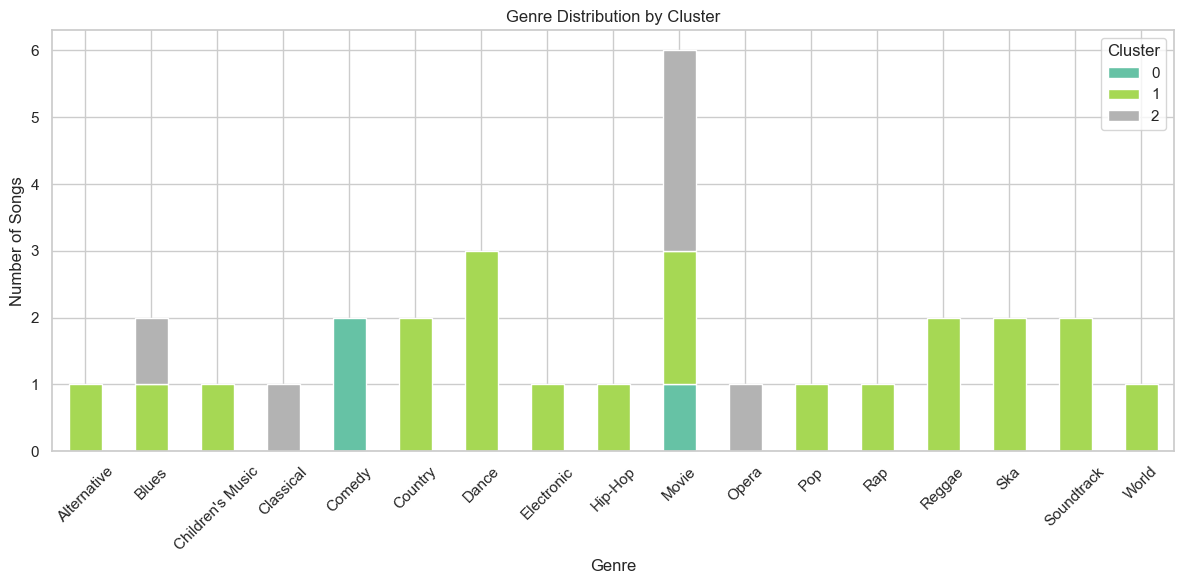

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# First, group by cluster and genre and count occurrences
genre_counts = songs.groupby(['Cluster', 'genre']).size().unstack(fill_value=0)

# Plot as stacked bar
genre_counts.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title('Genre Distribution by Cluster')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


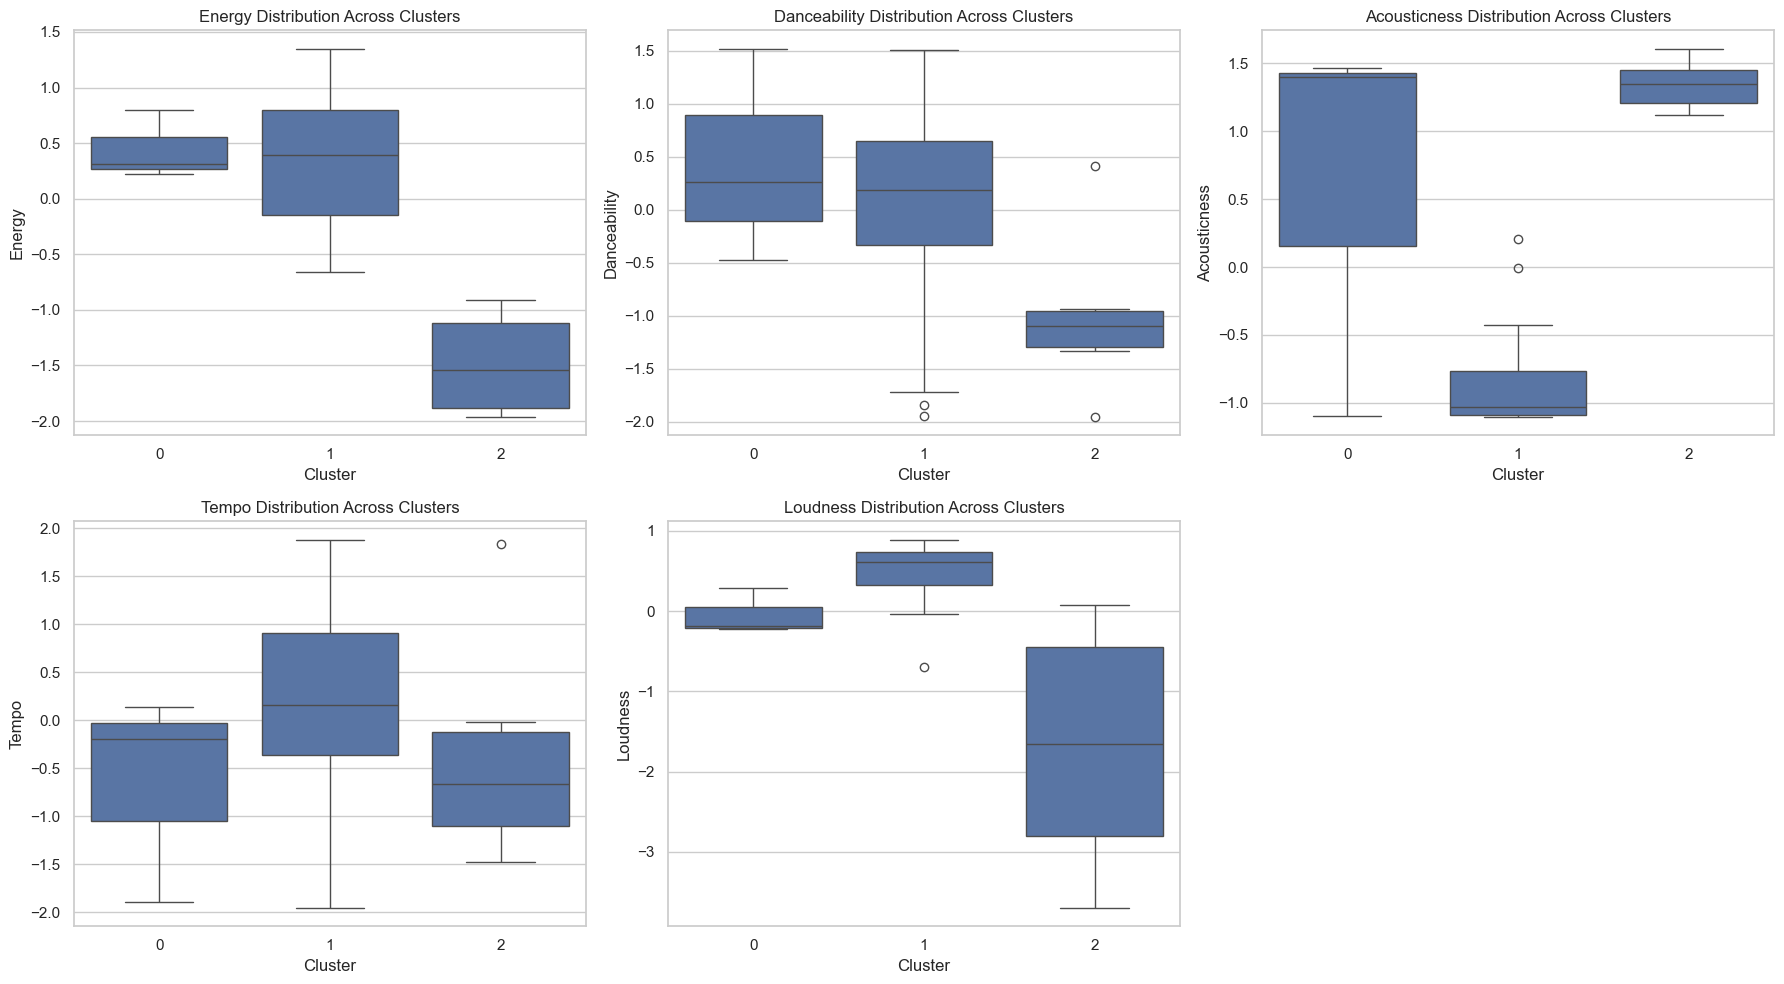

In [39]:
# poltting 30 somgs festures to visualise and compare their features

plot_data = pd.concat([pd.DataFrame(scaled, columns=features), pd.Series(clusters, name='Cluster')], axis=1)
selected_features = ['energy', 'danceability', 'acousticness', 'tempo', 'loudness']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, feature in enumerate(selected_features):
    sns.boxplot(x='Cluster', y=feature, data=plot_data, ax=axs[i])
    axs[i].set_title(f'{feature.capitalize()} Distribution Across Clusters')
    axs[i].set_xlabel('Cluster')
    axs[i].set_ylabel(feature.capitalize())

for j in range(len(selected_features), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


## Method-3:Matrix Completion

#### Low-rank approximation using SVD

In [42]:
# Performing SVD
def fit_svd(X, M):
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    return U[:, :M] @ np.diag(s[:M]) @ Vt[:M, :]

#### Iterating until there is minor change in matrix iteration

In [44]:
# Performing Matrix Completion
def matrix_completion_algo12(Xna, M, row_index, column_index, thresh=1e-5, max_iter=100, verbose=False):
    Xhat = Xna.copy()
    xbar = np.nanmean(Xna, axis=0)
    Xhat[row_index, column_index] = xbar[column_index]

    ismiss = np.isnan(Xna)

    mss0 = np.mean(np.square(Xna[~ismiss]))
    mssold = mss0
    rel_err = 1
    iter_ = 0
    errors = []

    while rel_err > thresh and iter_ < max_iter:
        iter_ += 1
        Xapp = fit_svd(Xhat, M)
        Xhat[ismiss] = Xapp[ismiss]
        mss = np.mean(np.square(Xna[~ismiss] - Xapp[~ismiss]))
        rel_err = float((mssold - mss) / mss0)

        mssold = mss
        errors.append(rel_err)

        if verbose:
            print(f"Iter: {iter_}, MSS: {mss:.6f}, Rel. Err: {rel_err:.6e}")

    return Xhat, errors, iter_

#### Imputing missing values based on approximation

In [46]:
# Evaluate Matrix Completion
spotify_scaled_array = spotify_scaled_df.values
missing_fractions = np.arange(0.05, 0.30, 0.05)
M_values = np.arange(1, 9)
repetitions = 5
error_matrix = np.zeros((len(missing_fractions), len(M_values)))

for i, frac in enumerate(missing_fractions):
    for j, M in enumerate(M_values):
        total_error = 0
        for _ in range(repetitions):
            Xna = spotify_scaled_array.copy()
            num_missing = int(Xna.size * frac)
            
            row_index = np.random.randint(0, Xna.shape[0], size=num_missing)
            column_index = np.random.randint(0, Xna.shape[1], size=num_missing)

            Xna[row_index, column_index] = np.nan

            # Apply Matrix Completion
            X_completed, _, _ = matrix_completion_algo12(Xna, M, row_index, column_index)

            # Calculate Reconstruction Error
            error = np.linalg.norm(X_completed[row_index, column_index] - spotify_scaled_array[row_index, column_index]) / np.linalg.norm(spotify_scaled_array[row_index, column_index])
            total_error += error

        error_matrix[i, j] = total_error / repetitions

In [47]:
# Format Error Matrix
row_labels = [f"{int(p*100)}%" for p in missing_fractions]
col_labels = [f"M={m}" for m in M_values]

error_df = pd.DataFrame(error_matrix, index=row_labels, columns=col_labels)
print("Average Approximation Errors:")
print(error_df)

Average Approximation Errors:
          M=1       M=2       M=3       M=4       M=5       M=6       M=7  \
5%   0.875496  0.856773  0.872581  0.948582  1.191409  1.446699  1.851990   
10%  0.879613  0.866008  0.891291  0.981000  1.257219  1.482865  1.901354   
15%  0.881830  0.875819  0.913186  1.014122  1.330853  1.552464  1.844533   
20%  0.885665  0.885984  0.934655  1.048920  1.429910  1.591729  1.774490   
25%  0.888147  0.896656  0.961510  1.089245  1.494253  1.594474  1.723971   

          M=8  
5%   1.861028  
10%  1.830181  
15%  1.726528  
20%  1.643882  
25%  1.566771  


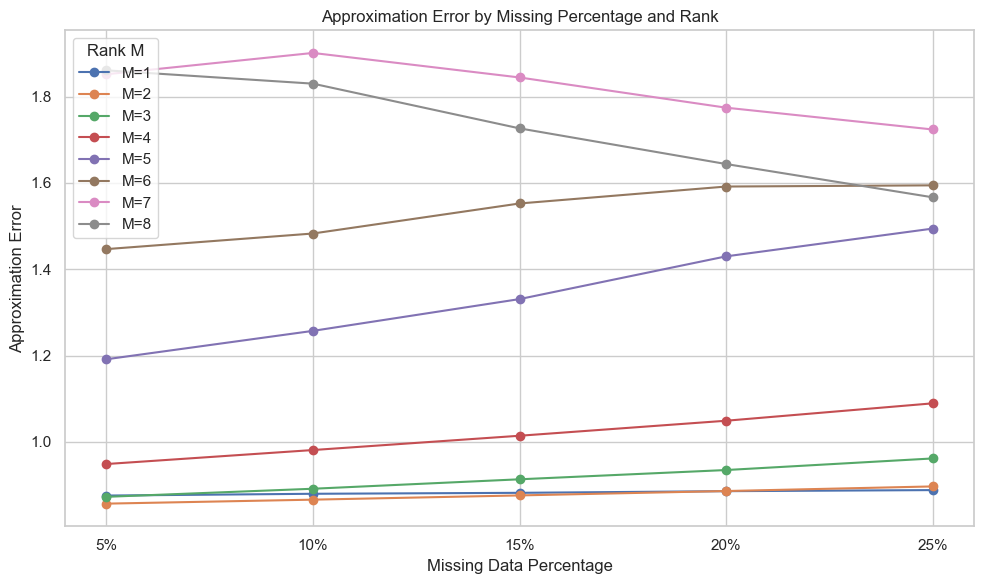

In [48]:
# Plot 
plt.figure(figsize=(10, 6))
for col in error_df.columns:
    plt.plot(error_df.index, error_df[col], marker='o', label=col)

plt.title("Approximation Error by Missing Percentage and Rank")
plt.xlabel("Missing Data Percentage")
plt.ylabel("Approximation Error")
plt.legend(title="Rank M")
plt.grid(True)
plt.tight_layout()
plt.show()

**So, now we will evaluate how stable KMeans clustering is after applying matrix completion with different low-rank approximations (M=1 to 8) on the Spotify dataset with 10% missing values.**

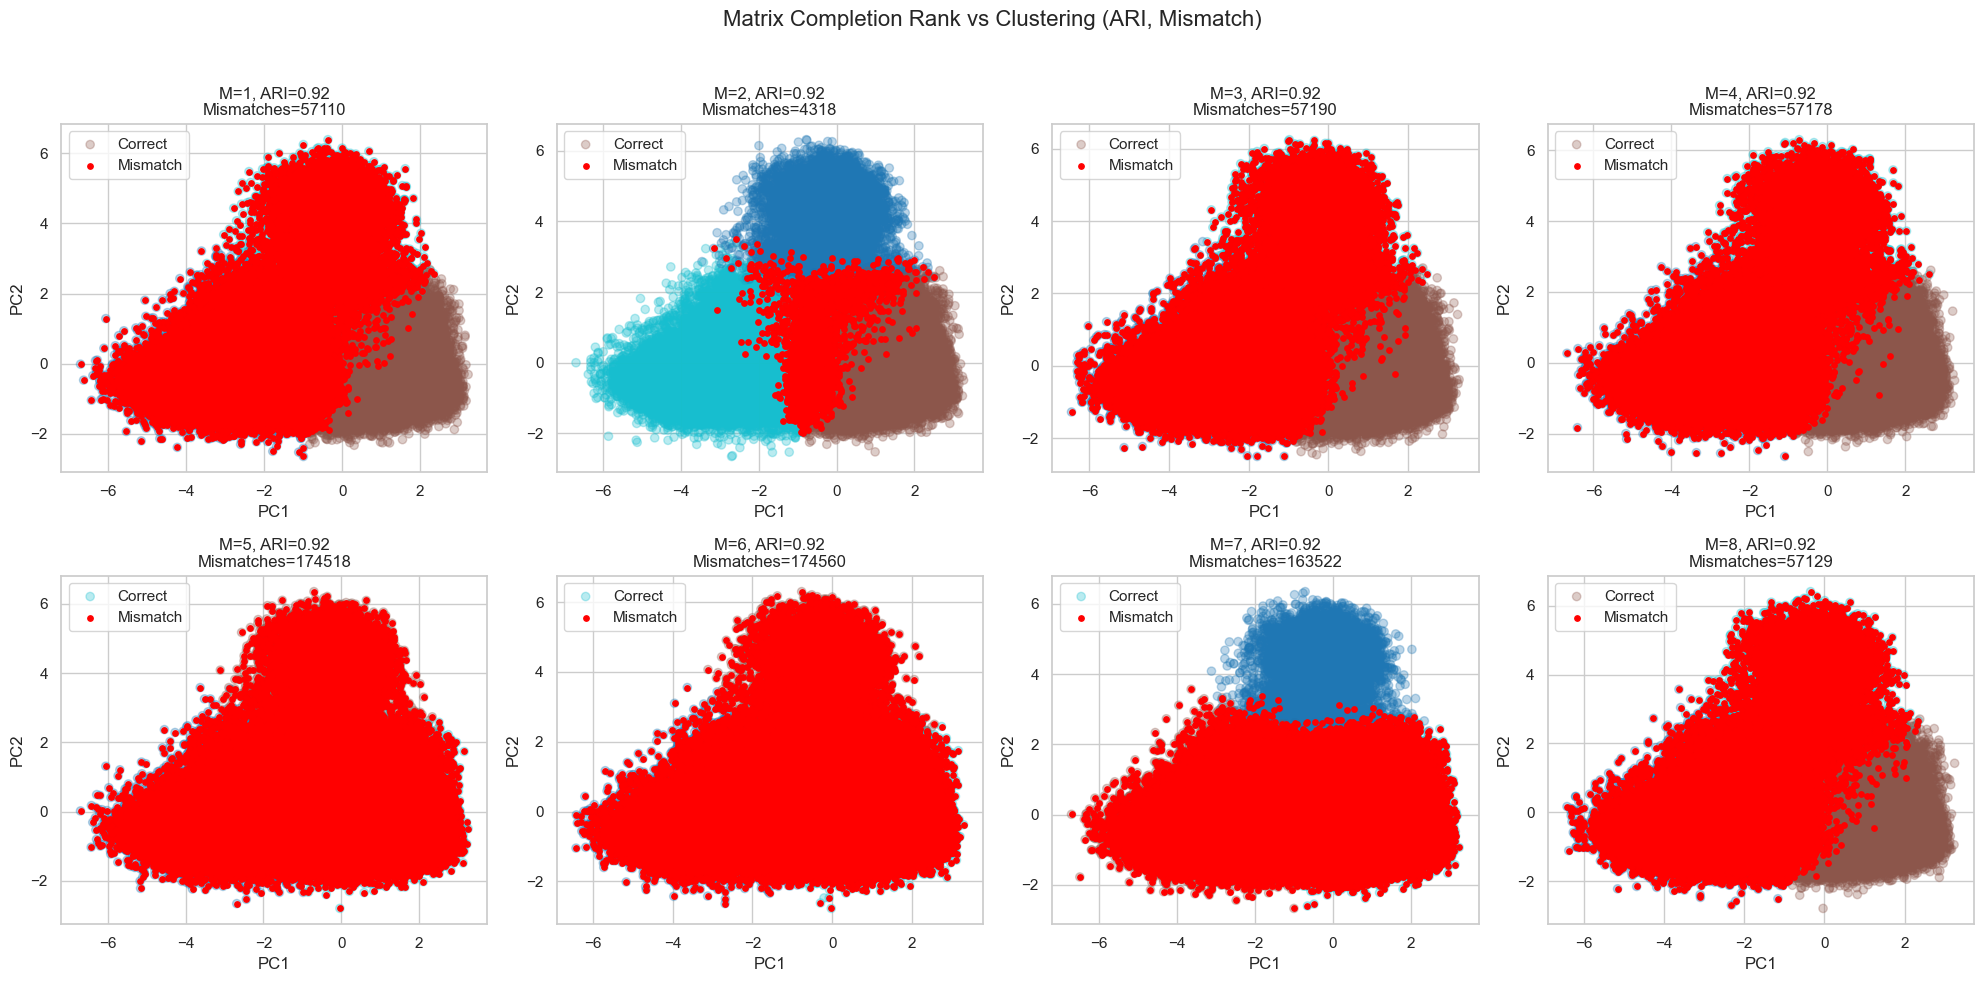

In [50]:

ari_scores = []
mismatch_counts = []
ranks = range(1, 9)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

pca_full = PCA(n_components=2)
X_pca_full = pca_full.fit_transform(spotify_scaled_df.values)
kmeans_full = KMeans(n_clusters=3, random_state=42)
labels_full = kmeans_full.fit_predict(spotify_scaled_df.values)

np.random.seed(42)  

for i, M in enumerate(ranks):
    np.random.seed(42 + M)
    X_full = spotify_scaled_df.values.copy()
    missing_mask = np.random.rand(*X_full.shape) < 0.10
    Xna = X_full.copy()
    Xna[missing_mask] = np.nan

    # Impute Missing Values
    col_means = np.nanmean(Xna, axis=0)
    for col in range(Xna.shape[1]):
        Xna[np.isnan(Xna[:, col]), col] = col_means[col]

    # Apply Matrix Completion and Clustering
    row_idx, col_idx = np.where(missing_mask)
    X_completed, _, _ = matrix_completion_algo12(Xna, M=M, row_index=row_idx, column_index=col_idx)

    pca_mc = PCA(n_components=2)
    X_pca_mc = pca_mc.fit_transform(X_completed)
    kmeans_mc = KMeans(n_clusters=3, random_state=42)
    labels_mc = kmeans_mc.fit_predict(X_completed)

    mismatch_mask = labels_mc != labels_full
    mismatch_count = np.sum(mismatch_mask)
    ari = adjusted_rand_score(labels_full, labels_mc)

    ari_scores.append(ari)
    mismatch_counts.append(mismatch_count)

    # Plot Clusters and Mismatches
    axes[i].scatter(X_pca_mc[:, 0], X_pca_mc[:, 1], c=labels_mc, cmap='tab10', alpha=0.3, label='Correct')
    axes[i].scatter(X_pca_mc[mismatch_mask, 0], X_pca_mc[mismatch_mask, 1], c='red', s=15, label='Mismatch')

    axes[i].set_title(f"M={M}, ARI={ari:.2f}\nMismatches={mismatch_count}")
    axes[i].set_xlabel("PC1")
    axes[i].set_ylabel("PC2")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Matrix Completion Rank vs Clustering (ARI, Mismatch)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

* M=2 has the fewest mismatches (4318), suggesting it is quite similar and aligned with original clusters.
* M=5–6 have massive mismatch counts of ariund 160k-170k, suggesting poor alignment with original clusters even though having similar ARI.
* This indicates that ARI alone isn't sufficient to evaluate rank performance on missing data.
* It is obvious that low rank approximation **M=2** is suffficient to impute missing value and perfectly alignd with original cluster giving lowest approximation error.


### H Clustering

**so, now we will perform hierarchical clustering analysis on a sample of your Spotify dataset using multiple linkage methods, and visualizing the results via dendrograms.**

we will explore the structure of Spotify music data to identify whether genre-based groupings happens by performing hierarchical clustering on a scaled sample of audio features. 
Then we will compare clustering behavior across different linkage methods—single, complete, average, and centroid using ecludiean distance and how it seprates clusters.
The dendrograms are labeled with genre and songname, which is easy for idntifying grouping patterns of different genre based on feature similarity and dissimilarity.
For better interability we used only 100 subsamples from original dataset.

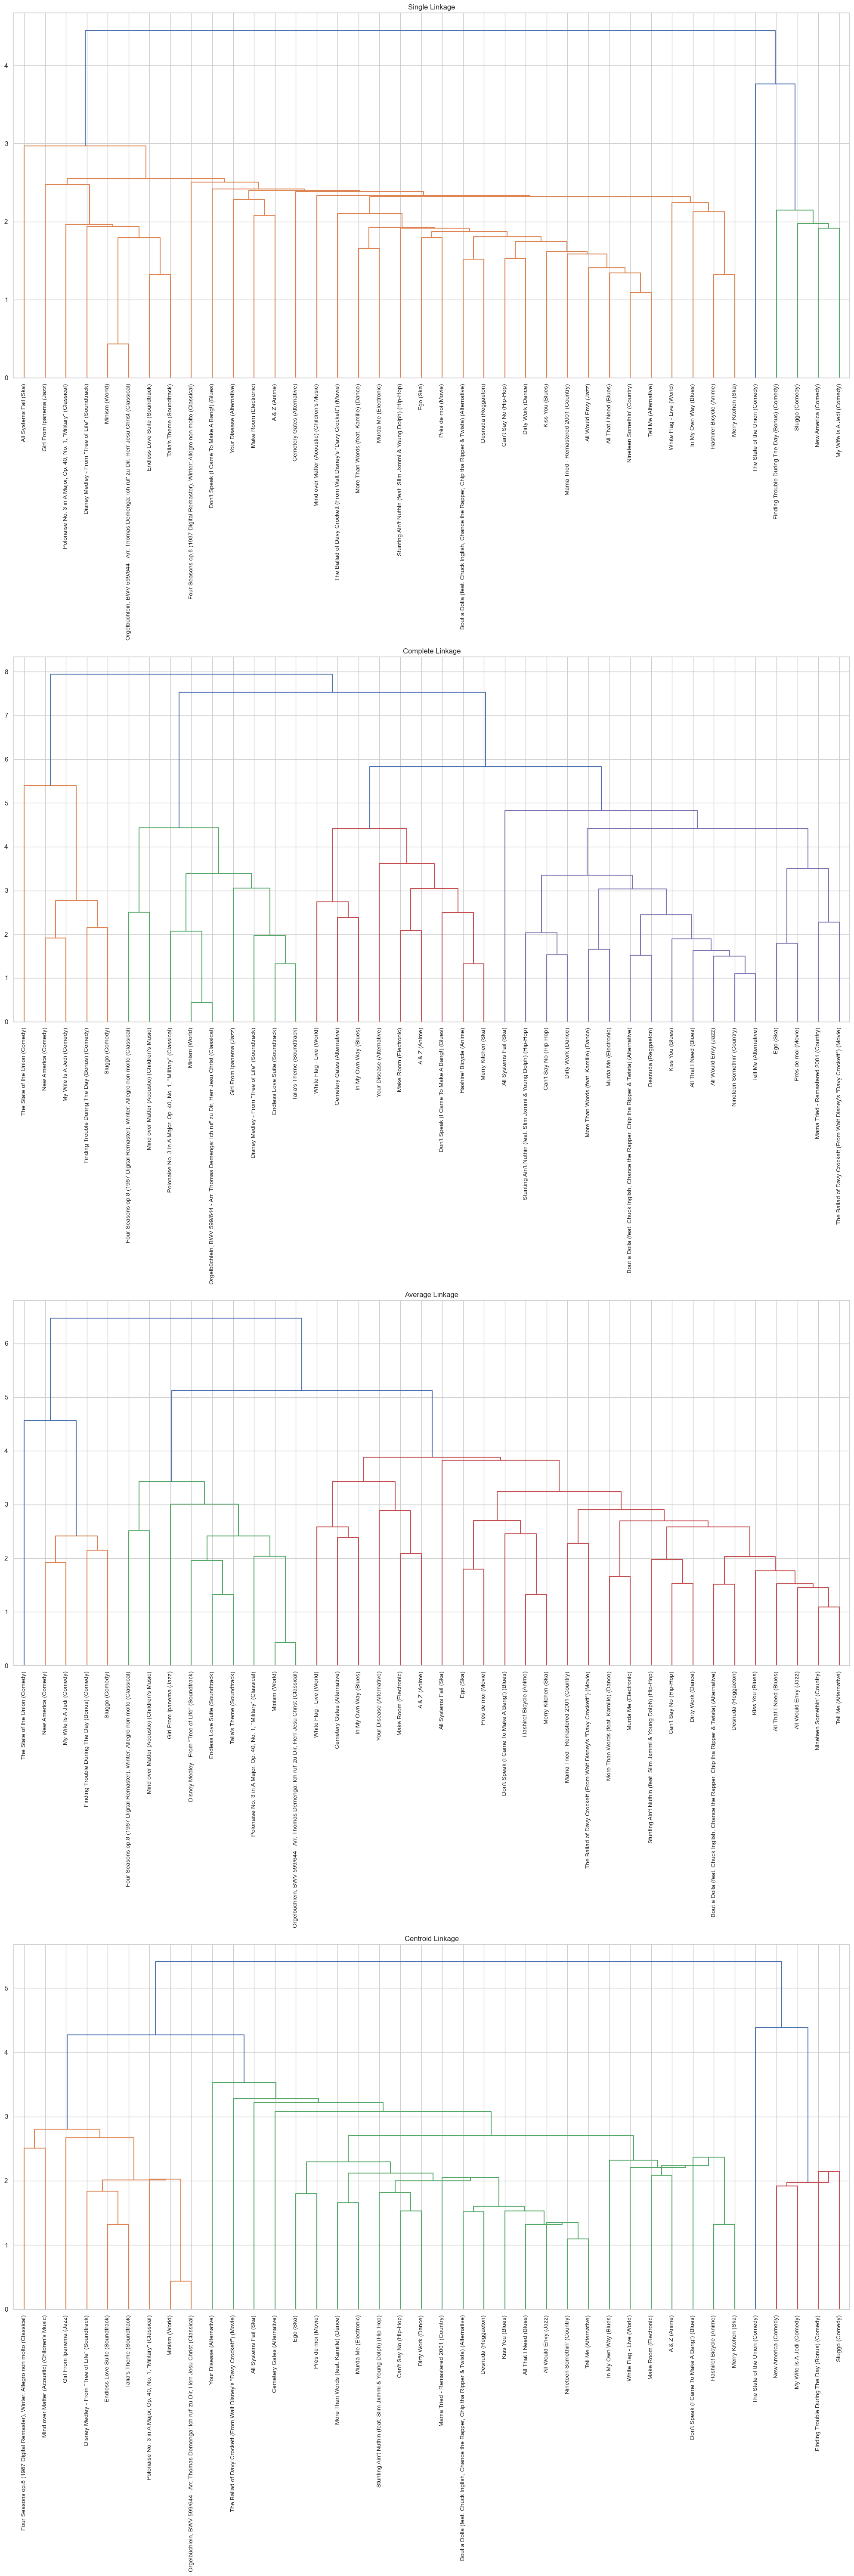

In [55]:

features = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
            'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

spotify_clean = spotify_df.dropna(subset=features + ['genre', 'track_name'])
spotify_sample = spotify_clean.sample(10000, random_state=123)
spotify_scaled = StandardScaler().fit_transform(spotify_sample[features])
spotify_labels = spotify_sample['genre'].reset_index(drop=True)

# only having 100 subsample from original dataset 
np.random.seed(42)
sample_indices = np.random.choice(range(len(spotify_sample)), size=40, replace=False)
sample_data = spotify_scaled[sample_indices]
sample_labels = [
    f"{spotify_sample.iloc[i]['track_name']} ({spotify_sample.iloc[i]['genre']})"
    for i in sample_indices
]

# Plot Dendrograms 
linkage_methods = ['single', 'complete', 'average', 'centroid']
plt.figure(figsize=(20, 60))

for i, method in enumerate(linkage_methods, 1):
    plt.subplot(4,1, i)
    Z = linkage(sample_data, method=method, metric='euclidean')
    dendrogram(Z, labels=sample_labels, leaf_rotation=90, leaf_font_size=10)
    plt.title(f"{method.capitalize()} Linkage")

plt.tight_layout()
plt.show()

* single linkage dendrogram shows chain-like clustering, indicating that many genres are merging with minimal separation, which makes harder to identify didtinct clusters and seperate them.
* complete linkage dendrogram shows more well-separated and tight clusters than single linkage, and showing seperatio between some genre groups based on audio features.
* Average linkage is also providing balance tree structure but there is gradual merging and shows good seperation.
* centroid linkage dendrogram is also having haining and occasional which is affecting clear seperation in genre-based grouping.


In [57]:
# Define Linkage Methods to Evaluate
linkage_methods = ['single', 'complete', 'average', 'centroid']

# Compute and Print Cluster-Genre Cross-Tabs
for method in linkage_methods:
    Z = linkage(spotify_scaled, method=method, metric='euclidean')
    clusters = cut_tree(Z, n_clusters=10).reshape(-1)
    ctab = pd.crosstab(spotify_labels, pd.Series(clusters, name='Cluster'))
    print(f"\n{method.capitalize()} Linkage - Genre vs Cluster")
    print(ctab)


Single Linkage - Genre vs Cluster
Cluster             0  1  2  3  4  5  6  7  8  9
genre                                           
A Capella           5  0  0  0  0  0  0  0  0  0
Alternative       539  0  0  0  0  0  0  0  0  0
Anime             521  0  0  0  0  0  0  0  0  0
Blues             508  0  0  0  0  0  0  0  0  0
Children's Music  364  0  0  0  0  0  0  0  0  0
Classical         517  1  1  1  0  0  1  0  0  0
Comedy            533  0  2  0  0  0  0  0  0  0
Country           407  0  0  0  0  0  0  0  0  0
Dance             421  0  0  0  0  0  0  0  0  0
Electronic        521  0  0  0  0  0  0  0  0  0
Folk              417  0  0  0  0  0  0  0  0  0
Hip-Hop           429  0  0  0  1  0  0  0  0  0
Indie             188  0  0  0  0  0  0  0  0  0
Jazz              428  0  0  0  0  1  0  0  0  0
Movie             452  0  3  0  0  0  0  0  1  0
Opera             476  0  0  0  0  0  0  0  0  1
Pop               133  0  0  0  0  0  0  0  0  0
R&B               292  0  0  0  0 

* As seen from the abov cmap of trying to sepearte the 10000 samples using various linkage methods into 10 distinct cluster based on genre and various sound features using euclidean distance.
* Single Linkage forms only one big cluster,and completely fail to distinct genres into different clusters.
* Complete Linkage distributes genres more distinctly across clusters with better separation.
* Average LinkageLinkage distributes was only able to form 3 good clusters and other data poins which are far from this fomed small clusters which more looks like outlier and hence perform moderate as compared to complete linkage.
* Average Linkage also perfomed similary to sinle linkage merging everything into a single cluster, showing no useful separation.
* Hence, average linkage offers the best genre-aware grouping for Spotify features among the four methods.

### PCA based Hirearchial Clustering

**Since the dataset has many numerical features, we will now try to reduce dimensionality and hence it will reduce feature set components and not consider non correlated features.**
We will perform Hclustering based on euclidean distance based on complete linkage as it is the best as compared to other methods proven from avove graphs and cmap. Using euclidean distance and  PCA transforms the data to its most informative structure, making clustering more meaningful. As we seen in kmeans PCA components elbow graph 5-6 components are sufficient to represent above 80% of variance. Similarly we are using only 6 PCA components which will lowers the computational burden of computing pairwise distances in linkage.

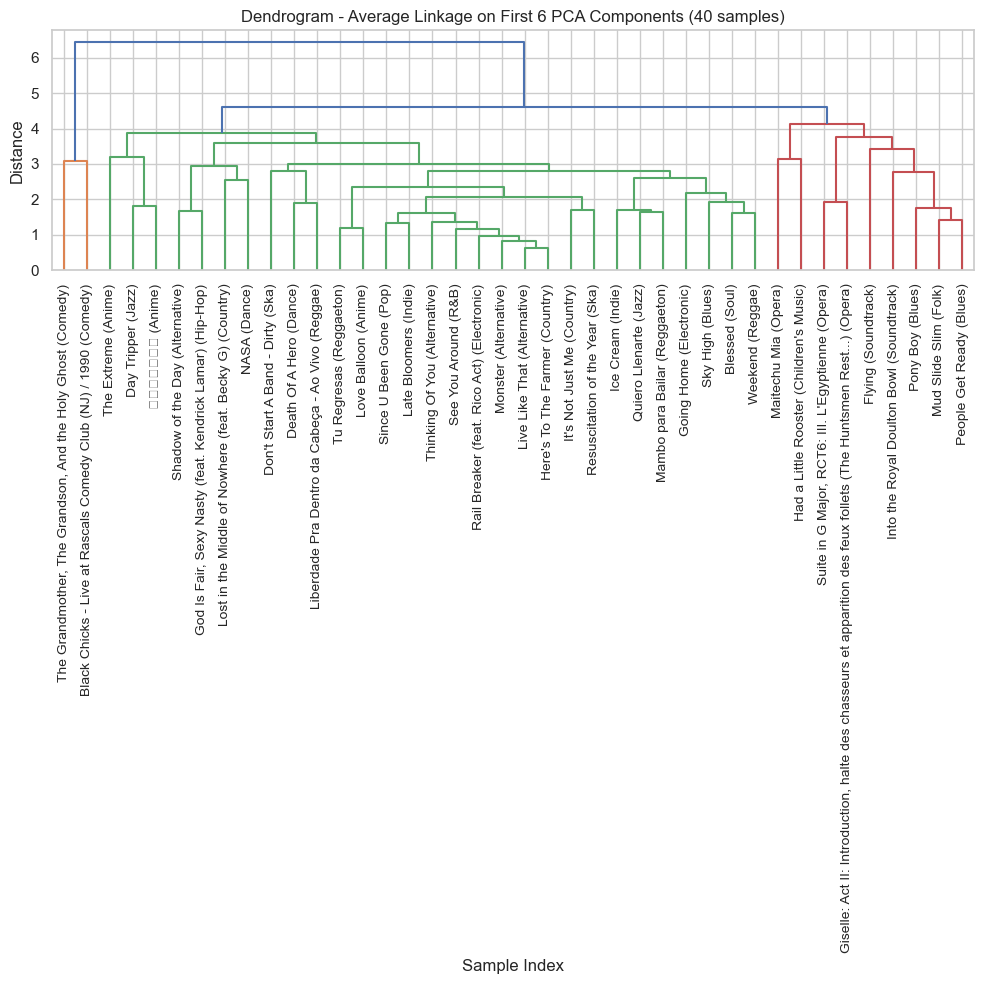

In [140]:
# PCA and Sample 100 Entries for Dendrogram
pca = PCA(n_components=6)
spotify_pca = pca.fit_transform(spotify_scaled)
sample_indices = np.random.choice(range(len(spotify_pca)), size=40, replace=False)
spotify_pca_subset = spotify_pca[sample_indices]
sample_labels = [
    f"{spotify_sample.iloc[i]['track_name']} ({spotify_sample.iloc[i]['genre']})"
    for i in sample_indices
]
hc_pca = linkage(spotify_pca_subset, method='average')

# Show PCA-based Dendrogram with Labels
plt.figure(figsize=(10, 10))
dendrogram(hc_pca, labels=sample_labels,leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram - Average Linkage on First 6 PCA Components (40 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

* The long vertical lines near the top at height 6 indicate large distances between final cluster merges, suggesting well-separated groupings and a natural cut-off around 3–4 clusters.

## Comparing pca based HClustering and K-means clustering

In [118]:

features = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
            'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

spotify_clean = spotify_df.dropna(subset=features + ['genre'])
spotify_sample = spotify_clean.sample(frac=1.0, random_state=42) 
spotify_scaled = StandardScaler().fit_transform(spotify_sample[features])
spotify_genres = spotify_sample['genre'].reset_index(drop=True)

# Encode Genre
genre_names = spotify_genres.astype('category').cat.categories.tolist()
encoded_labels = spotify_genres.astype('category').cat.codes

# PCA and Sample 100 Entries for Dendrogram
pca = PCA(n_components=6)
spotify_pca = pca.fit_transform(spotify_scaled)
sample_indices = np.random.choice(range(len(spotify_pca)), size=50, replace=False)
spotify_pca_subset = spotify_pca[sample_indices]
true_labels = encoded_labels.iloc[sample_indices].values
sample_labels = [
    f"{spotify_sample.iloc[i]['track_name']} ({spotify_sample.iloc[i]['genre']})"
    for i in sample_indices
]

# Hierarchical Clustering
hc_pca = linkage(spotify_pca_subset, method='complete')
hc_clusters = cut_tree(hc_pca, n_clusters=3).reshape(-1)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(spotify_pca_subset)
kmeans_clusters = kmeans.labels_

# Confusion Matrices
print("Hierarchical Clustering vs Genre (encoded):")
print(pd.crosstab(pd.Series(true_labels, name='Genre'), pd.Series(hc_clusters, name='HClust')))

print("\nK-Means Clustering vs Genre (encoded):")
print(pd.crosstab(pd.Series(true_labels, name='Genre'), pd.Series(kmeans_clusters, name='KMeans')))


Hierarchical Clustering vs Genre (encoded):
HClust  0  1  2
Genre          
1       0  4  0
2       1  1  0
3       0  2  0
4       0  3  0
5       4  1  0
6       0  0  1
7       0  2  0
8       0  1  0
9       3  2  1
10      0  1  0
11      0  1  0
12      0  1  0
13      0  3  0
14      1  3  0
15      2  0  1
19      0  2  0
20      0  1  0
22      0  3  0
24      3  1  0
25      1  0  0

K-Means Clustering vs Genre (encoded):
KMeans  0  1  2
Genre          
1       0  4  0
2       0  0  2
3       0  0  2
4       0  0  3
5       4  0  1
6       1  0  0
7       0  1  1
8       0  1  0
9       0  4  2
10      1  0  0
11      0  1  0
12      0  1  0
13      2  1  0
14      4  0  0
15      3  0  0
19      0  1  1
20      0  1  0
22      0  0  3
24      4  0  0
25      1  0  0


* Hclust the assignment of data points is mostly to cluster1 while the data points are well distributed well in kmeans as compared to HClustering but kmeans also performing moderatly.
* Kmeans performed better in cluster seperation as it has iterative approach while hclusteing not able to didtinct that might be possible due to early wrong decision which cannot be undone and lead to bad clustering.

In [121]:

# Compute and Display ARI and Silhouette Score
ari_hc = adjusted_rand_score(true_labels, hc_clusters)
ari_km = adjusted_rand_score(true_labels, kmeans_clusters)
sil_hc = silhouette_score(spotify_pca_subset, hc_clusters)
sil_km = silhouette_score(spotify_pca_subset, kmeans_clusters)

print(f"\nAdjusted Rand Index - HClust: {ari_hc:.4f}, KMeans: {ari_km:.4f}")
print(f"Silhouette Score - HClust: {sil_hc:.4f}, KMeans: {sil_km:.4f}")



Adjusted Rand Index - HClust: 0.0195, KMeans: 0.1129
Silhouette Score - HClust: 0.2590, KMeans: 0.2091


* HClust (0.2590) has a much higher silhouette score than KMeans (0.2091), meaning the clusters from HClust are more compact and better separated from each other in the feature space.
* HClust creates more tightly grouped and distinct clusters (better silhouette), but these don't match real genres well.
* KMeans does a bit better in matching actual genres (higher ARI), but its clusters are less cleanly separated.
* This shows a trade-off: HClust gives cleaner groups, while KMeans captures genre trends slightly better

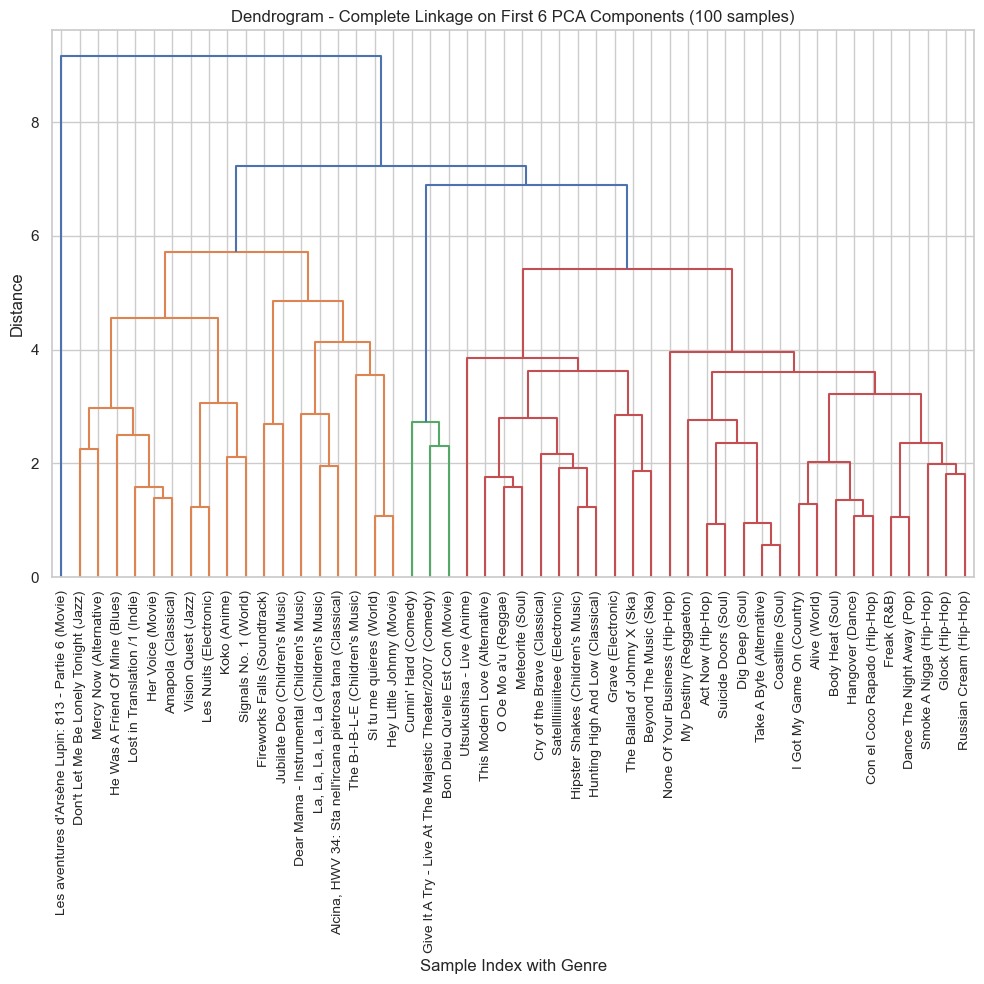

In [68]:

# PCA and Sample 100 Entries for Dendrogram with Labels
plt.figure(figsize=(10, 10))
dendrogram(hc_pca, labels=sample_labels, leaf_font_size=10)
plt.title("Dendrogram - Complete Linkage on First 6 PCA Components (100 samples)")
plt.xlabel("Sample Index with Genre")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()